In [1]:
import os

os.environ['TORCH_USE_CUDA_DSA'] = '1'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import densenet121
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device("cuda")

In [63]:
df = pd.read_excel('oasis_cross-sectional.xlsx')
folders = os.listdir("Data")
imageData = []
for state in folders:
    filePath = "Data" + "\\" + state
    for fileName in os.listdir(filePath):
        if fileName.endswith(".jpg") or fileName.endswith(".png"):
            imageData.append({"imagePath": os.path.join(filePath,fileName), "label": state})

imageDataFrame = pd.DataFrame(imageData)

In [64]:
class DenseCNN(nn.Module):
    def __init__(self):
        super(DenseCNN, self).__init__()
        self.densenet = densenet121(pretrained=False)

    def forward(self, x):
        return self.densenet(x)


In [65]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

imageDataFrame = imageDataFrame.sample(frac=0.3).reset_index(drop=True)

images = []
labels = []
for index, row in imageDataFrame.iterrows():
    imagePath = row['imagePath']
    imageTensor = transform(Image.open(imagePath).convert('RGB'))
    if imageTensor is not None:
        images.append(transform(Image.open(imagePath).convert('RGB')))
        labels.append(row['label'])
tensorImages = torch.stack(images)
tensorLabels = torch.tensor(pd.factorize(labels)[0])

dataset = TensorDataset(tensorImages, tensorLabels)
dataloader = DataLoader(TensorDataset(tensorImages, tensorLabels), batch_size=32, shuffle=True)
model = DenseCNN().to(device)
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
trainingDataset, validationDataset = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
trainingDataloader = DataLoader(trainingDataset, batch_size=32, shuffle=True)
validationDataloader = DataLoader(validationDataset, batch_size=32, shuffle=True)


C:\Users\Shark\AppData\Local\Temp\ipykernel_3472\4247233629.py:17: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tensorLabels = torch.tensor(pd.factorize(labels)[0])
C:\Users\Shark\PycharmProjects\baseline\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shark\PycharmProjects\baseline\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [66]:
def train(model, optimizer, epochs):
    model.train()
    print("Training for", epochs, "epochs")
    for epoch in range(0, epochs):
        model.train()
        trainingLoss = 0.0
        correct = 0
        total = 0
        for inputs, labels in trainingDataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossFunction(outputs, labels)
            loss.backward()
            optimizer.step()

            trainingLoss += loss.item()
            predicted = torch.max(outputs.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        trainingLoss /= len(trainingDataloader)
        trainingAccuracy = correct / total

        model.eval()
        validationLoss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in validationDataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = lossFunction(outputs, labels)
                validationLoss += loss.item()
                predicted = torch.max(outputs.data, 1)[1]
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validationLoss /= len(validationDataloader)
        val_accuracy = correct / total
        print("Epoch: ", epoch+1, " | Training loss: ", round(trainingLoss, 3), " | Validation loss: ", round(validationLoss, 3), " | Training accuracy: ", round(trainingAccuracy, 3), " | Validation accuracy: ", round(val_accuracy, 3))

In [67]:
device = torch.device("cuda")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

train(model, optimizer, 10)

Training for 10 epochs
Epoch:  1  | Training loss:  0.805  | Validation loss:  0.284  | Training accuracy:  0.819  | Validation accuracy:  0.894
Epoch:  2  | Training loss:  0.171  | Validation loss:  0.264  | Training accuracy:  0.941  | Validation accuracy:  0.911
Epoch:  3  | Training loss:  0.072  | Validation loss:  0.092  | Training accuracy:  0.977  | Validation accuracy:  0.965
Epoch:  4  | Training loss:  0.045  | Validation loss:  0.147  | Training accuracy:  0.986  | Validation accuracy:  0.947
Epoch:  5  | Training loss:  0.029  | Validation loss:  0.024  | Training accuracy:  0.991  | Validation accuracy:  0.993
Epoch:  6  | Training loss:  0.027  | Validation loss:  0.072  | Training accuracy:  0.992  | Validation accuracy:  0.973
Epoch:  7  | Training loss:  0.02  | Validation loss:  0.106  | Training accuracy:  0.994  | Validation accuracy:  0.971
Epoch:  8  | Training loss:  0.025  | Validation loss:  0.067  | Training accuracy:  0.991  | Validation accuracy:  0.975
Ep

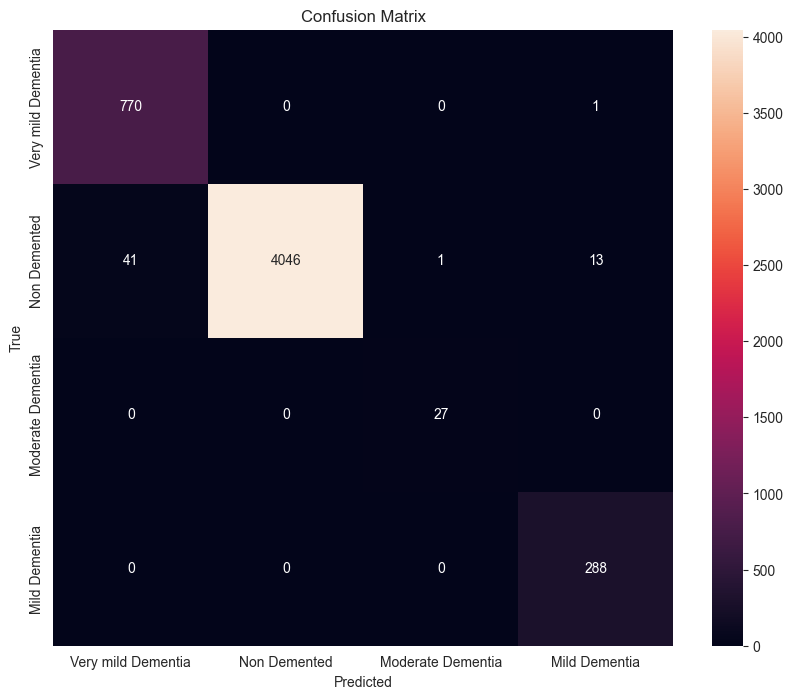

In [68]:
confusionPredictions = []
confusionLabels = []
with torch.no_grad():
        for inputs, labels in validationDataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.max(outputs.data, 1)[1]
            confusionPredictions.extend(labels.cpu().numpy())
            confusionLabels.extend(predicted.cpu().numpy())
y_true, y_pred = np.array(confusionLabels), np.array(confusionPredictions)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
classNames = imageDataFrame['label'].unique()
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classNames, yticklabels=classNames)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()